# Processing data from wellknown tools to set pHLA binding baselines 

Process output files from well-known methods to set a baseline to compare with. This includes:
- `NetMHCpan` tested on:
    - `CD8_benchmark_filtered` (NetMHCpan original test set)

In [1]:
import os
import re
import glob
import pandas as pd

In [2]:
CHECKPOINTS_DIR = '../checkpoints'
BASELINES_DIR = os.path.join(CHECKPOINTS_DIR, 'baselines')
NETMHCPAN_BASELINE_DIR = os.path.join(BASELINES_DIR, 'netmhcpan41')
RAW_NETMHCPAN_CD8_BENCHMARK_DIR = os.path.join(NETMHCPAN_BASELINE_DIR, 'CD8_benchmark_filtered_outs')
out_merged_netmhcpan_cd8_benchmark_file = os.path.join(NETMHCPAN_BASELINE_DIR, 'CD8_benchmark_filtered_outs.csv.gz')

In [3]:
def parse_netmhcpan_output_to_df(file_path):
    # Read the file
    with open(file_path, 'r') as file:
        data = file.read()
    
    # Split the data into lines and remove headers
    lines = data.strip().split('\n')[48:]
    
    # Define column names
    columns = ["Pos", "MHC", "Peptide", "Core", "Of", "Gp", "Gl", "Ip", "Il", "Icore", "Identity", "Score_EL", "%Rank_EL", "Exp", "BindLevel"]
    
    # Parse each line into a list of values
    parsed_data = []
    for line in lines:
        # Use regex to handle the fixed-width format
        match = re.match(r'(\s*\d+)\s+(\S+)\s+(\S+)\s+(\S+)\s+(\d+)\s+(\d+)\s+(\d+)\s+(\d+)\s+(\d+)\s+(\S+)\s+(\S*)\s+([\d.]+)\s+([\d.]+)\s+([\d.]+)(.*)', line)
        if match:
            parsed_data.append(match.groups())
    
    # Create DataFrame
    df = pd.DataFrame(parsed_data, columns=columns)
    
    return df

## CD8 benchmark

### Processing (only run once)
The dir has 1600 files, each file contains a set of peptides (with only one binder) for a specific HLA allele. 

In [5]:
# raw_cd8_netmhcpan_outfiles = glob.glob(os.path.join(RAW_NETMHCPAN_CD8_BENCHMARK_DIR, '*.out'))
# 
# # merge all files into a single dataframe
# dfs = []
# for file in raw_cd8_netmhcpan_outfiles:
#     df = parse_netmhcpan_output_to_df(file)
#     dfs.append(df)
#     
# cd8_netmhcpan_df = pd.concat(dfs)
# # replace bind level to 1 if SB, 0.5 if WB, 0 if NB (empty)
# cd8_netmhcpan_df['BindLevel'] = cd8_netmhcpan_df['BindLevel'].replace({' <= SB': 1, ' <= WB': 0.5, '': 0})
# # save relevant columns
# cd8_netmhcpan_df = cd8_netmhcpan_df[['MHC', 'Peptide', 'Score_EL', '%Rank_EL', 'Exp', 'BindLevel']]
# cd8_netmhcpan_df['Exp'] = cd8_netmhcpan_df['Exp'].astype(float)
# cd8_netmhcpan_df.to_csv(out_merged_netmhcpan_cd8_benchmark_file, index=False)

/tmp/ipykernel_15039/2744432468.py:9: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  cd8_netmhcpan_df['BindLevel'] = cd8_netmhcpan_df['BindLevel'].replace({' <= SB': 1, ' <= WB': 0.5, '': 0})


In [6]:
# cd8_netmhcpan_df.head()

,MHC,Peptide,Score_EL,%Rank_EL,Exp,BindLevel
0,HLA-A*02:01,MSHVVVKN,0.0000030,87.500,0.00000,0.0
1,HLA-A*02:01,SHVVVKND,0.0000000,100.000,0.00000,0.0
2,HLA-A*02:01,HVVVKNDP,0.0000070,78.333,0.00000,0.0
3,HLA-A*02:01,VVVKNDPE,0.0000120,71.250,0.00000,0.0
4,HLA-A*02:01,VVKNDPEL,0.0015740,14.932,0.00000,0.0


### CD8 benchmark load and evaluation

In [3]:
cd8_netmhcpan_df = pd.read_csv(out_merged_netmhcpan_cd8_benchmark_file)
cd8_netmhcpan_df.head()

,MHC,Peptide,Score_EL,%Rank_EL,Exp,BindLevel
0,HLA-A*02:01,MSHVVVKN,0.000003,87.500,0.0,0.0
1,HLA-A*02:01,SHVVVKND,0.000000,100.000,0.0,0.0
2,HLA-A*02:01,HVVVKNDP,0.000007,78.333,0.0,0.0
3,HLA-A*02:01,VVVKNDPE,0.000012,71.250,0.0,0.0
4,HLA-A*02:01,VVKNDPEL,0.001574,14.932,0.0,0.0


In [4]:
# compute roc auc
from sklearn.metrics import roc_auc_score
roc_auc_score(cd8_netmhcpan_df['Exp'], cd8_netmhcpan_df['Score_EL'])

0.9889863702709146

In [4]:
# compute confusion matrix
from sklearn.metrics import confusion_matrix
cm_rank_swb = confusion_matrix(
    cd8_netmhcpan_df['Exp'],
    cd8_netmhcpan_df['BindLevel'] > 0.4  # 0.4 is the threshold to include WB and SB
)
cm_rank_swb

array([[11043594,   163065],
       [     314,     1267]])

In [5]:
cm_rank_sb = confusion_matrix(
    cd8_netmhcpan_df['Exp'],
    cd8_netmhcpan_df['BindLevel'] > 0.6 # 0.6 is the threshold to NOT include WB (SB only)
)
cm_rank_sb

array([[11167109,    39550],
       [     677,      904]])

In [6]:
cm_el_score = confusion_matrix(
    cd8_netmhcpan_df['Exp'],
    cd8_netmhcpan_df['Score_EL'] > 0.5
)
cm_el_score

array([[11177308,    29351],
       [     791,      790]])

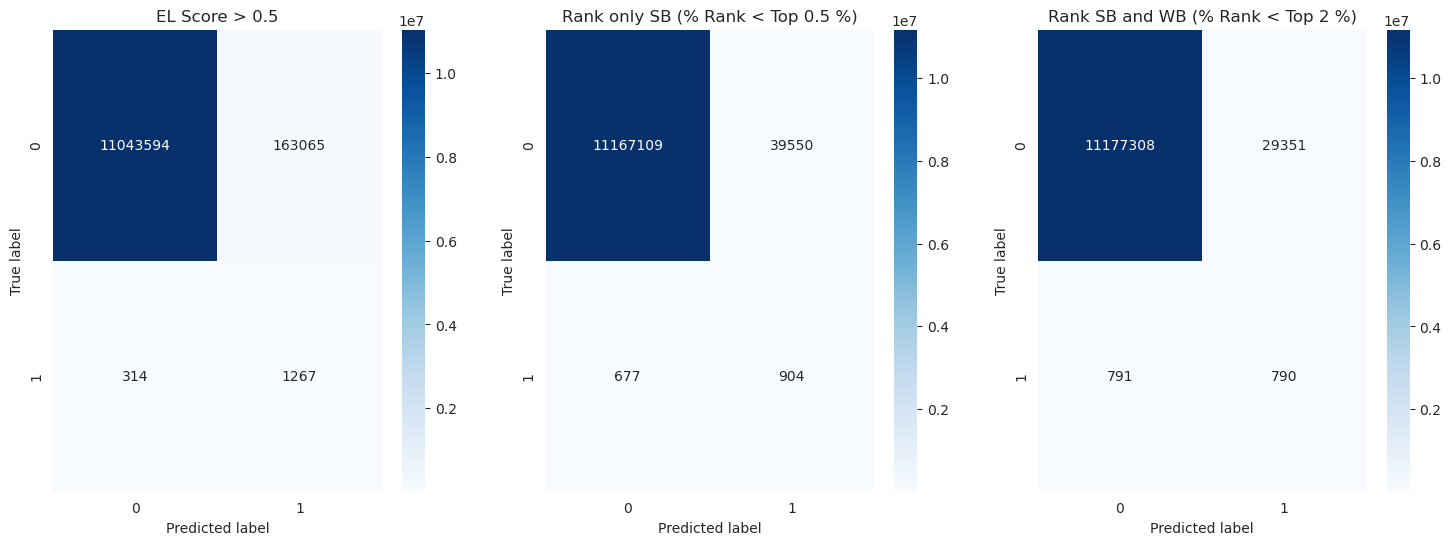

In [15]:
# plot the three confusion matrices
import matplotlib.pyplot as plt
import seaborn as sns

fig, axs = plt.subplots(1, 3, figsize=(18, 6))
sns.heatmap(cm_el_score, annot=True, fmt='d', ax=axs[2], cmap='Blues')
axs[0].set_title('EL Score > 0.5')
sns.heatmap(cm_rank_sb, annot=True, fmt='d', ax=axs[1], cmap='Blues')
axs[1].set_title('Rank only SB (% Rank < Top 0.5 %)')
sns.heatmap(cm_rank_swb, annot=True, fmt='d', ax=axs[0], cmap='Blues')
axs[2].set_title('Rank SB and WB (% Rank < Top 2 %)')

for i in range(3):
    axs[i].set_xlabel('Predicted label')
    axs[i].set_ylabel('True label')

plt.show()